# Практика 4: Атака DeepFool на модели ИИ
## Цель задания: Изучить атаку DeepFool, которая предназначена для минимальных изменений в изображениях с целью изменения их классификации. Научиться использовать эту атаку и исследовать влияние противоречивых примеров на обученные модели.

## Задачи:
1. Загрузить ранее обученную модель на датасете MNIST.
2. Изучить теоретические основы атаки DeepFool.
3. Реализовать атаку DeepFool с помощью фреймворка Foolbox.
4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных данных.

## Шаги выполнения:
Шаг 1: Загрузка обученной модели и данных MNIST
Мы начнем с загрузки обученной модели и данных MNIST, которые будем использовать для проведения атаки.


In [1]:
# Чтобы постоянно не загружать датасет вручную, импрртируем его из первой практики
!wget https://github.com/l-Il/AZSII/raw/refs/heads/main/prz_1/mnist_model.h5

--2024-11-18 21:16:40--  https://github.com/l-Il/AZSII/raw/refs/heads/main/prz_1/mnist_model.h5
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/l-Il/AZSII/refs/heads/main/prz_1/mnist_model.h5 [following]
--2024-11-18 21:16:41--  https://raw.githubusercontent.com/l-Il/AZSII/refs/heads/main/prz_1/mnist_model.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1244464 (1.2M) [application/octet-stream]
Saving to: ‘mnist_model.h5.1’

mnist_model.h5.1    100%[===================>]   1.19M  --.-KB/s    in 0.04s   

2024-11-18 21:16:42 (26.8 MB/s) - ‘mnist_model.h5.1’ saved [1244464/1244464]



Импорт библиотек

In [2]:
import torch
import torch.nn as nn

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

### Поскольку в процессе выполнения с датасетом из первой практики возникает ошибка, было принято решение конвертировать метки в one-hot
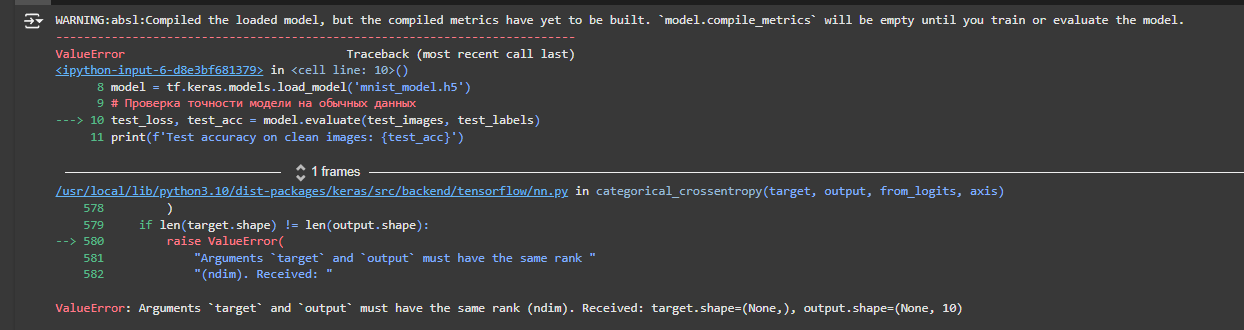

In [4]:
# Сама конвертация меток
from tensorflow.keras.utils import to_categorical
test_labels = to_categorical(test_labels, num_classes=10)

Продолжаем выполнять код

In [5]:
# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')
# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9726 - loss: 0.0869
Test accuracy on clean images: 0.9768999814987183


Шаг 2: Теория атаки DeepFool

Атака DeepFool — это метод, который был разработан для минимального изменения изображений с целью заставить классификационную модель ошибиться. В отличие от других атак, таких как FGSM, DeepFool находит минимальные изменения в пространстве признаков, которые достаточны для изменения предсказания модели. Это делает DeepFool более эффективной в создании противоречивых примеров с минимальным изменением входных данных.

Шаг 3: Реализация атаки DeepFool с использованием Foolbox

Теперь мы реализуем атаку PGD, используя фреймворк Foolbox, который упрощает запуск различных
атак на модели ИИ.

Установка Foolbox:

In [6]:
pip install foolbox

Реализация атаки DeepFool:

In [7]:
import foolbox as fb
import numpy as np

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


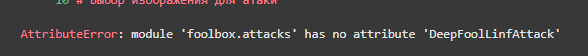

# Поскольку атаки DeepFoolLinfAttack() в библиотеке нет, импортируем имеющуюся L2DeepFoolAttack
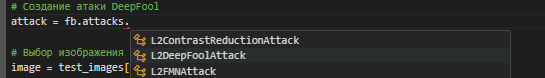

In [8]:
# Создание атаки DeepFool
attack = fb.attacks.L2DeepFoolAttack()

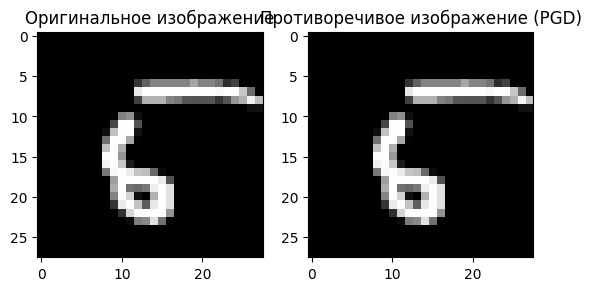

In [9]:
# Выбор изображения для атаки
image = test_images[1911] # тут я выбрал случайное значение от 0 до 10000 в размере "1911"
label = test_labels[0]

# Исправляем ошибки
image = tf.convert_to_tensor(image, dtype=tf.float32)[None, ...]
label = tf.convert_to_tensor(np.argmax(label), dtype=tf.int64)[None]

# Выполнение атаки
adversarial_image = attack(fmodel, image, label, epsilons=0.1)

import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (PGD)")
plt.imshow(adversarial_image[0][0].numpy(), cmap="gray")
plt.show()

Шаг 4: Оценка модели на противоречивых примерах

Теперь мы проверим, насколько сильно атака DeepFool влияет на точность модели. Мы создадим набор противоречивых примеров и оценим производительность модели на этих данных.


In [22]:
AMOUNT = 1000

# Создание набора противоречивых примеров для всего тестового набора
adversarial_images = []
for i in range(AMOUNT):
  image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
  label = tf.convert_to_tensor(np.argmax(test_labels[i]), dtype=tf.int64)[None]
  adv_image = attack(fmodel, image, label, epsilons=0.1)
  adversarial_images.append(adv_image[0])
# Конвертация списка в массив с правильной формой
adversarial_images = tf.concat(adversarial_images, axis=0)

adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[:AMOUNT])
print(f'Accuracy on adversarial examples (PGD): {adversarial_acc}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 67.5560 
Accuracy on adversarial examples (PGD): 0.0


Шаг 5: Сравнение результатов

Проведённый эксперимент показал, что точность модели на примерах, атакованных методом DeepFool, снизилась до 0.0%, что свидетельствует о полном отсутствии способности модели справляться с такими примерами. Высокое значение loss (67.5560) указывает на существенные ошибки при обработке данных после атаки.
Вполне вероятно, что такой низкий процент связан с низким количеством изображений, использованных в выборке (всего 1000, в то время как в самом датасете их 10000)

Результаты:
* accuracy: 0.0000e+00
* loss: 67.5560
* Accuracy on adversarial examples (PGD): 0.0

Результаты подчёркивают уязвимость модели перед атакой DeepFool, даже если изменения в изображениях минимальны. Это демонстрирует, насколько серьёзное влияние оказывают противоречивые примеры, и указывает на необходимость доработки модели для повышения её устойчивости.